# Parallelization of R code using the future package

In R, numerous packages can be used to parallelize code (parallel, snow, foreach, etc.), but each of  these packages use unique syntaxes and none of them work for all cases of parallelization. Instead, the [future package](https://github.com/HenrikBengtsson/future) solves this problem! Briefly (seet the [future package](https://github.com/HenrikBengtsson/future) for details), the future package works in three steps:

1. Choose how you want to parallelize your code
    - set the type of parallelization with the plan() object.  
2. Choose which part of the code you would like to run in parallel
    - place the part of the code that will be iterated within the future({}) object. 
3. Evaluate the code. 
    - run the iterations using the value() object. 

The power of the future package is it separates the planning for the parallelization (steps 1 and 2) and then executes the code aftward. This allows the user to control how and where to parallelize their own code. Thus, by learning the framework you can extend it to any iterative process.

Here are a few examples to demonstrate some common iterative problems in R: 

1. For-loop Example and basic structure
2. Tidyverse example using the furrr package
3. Bayesian example using multiple nodes via the future.batchtools package
4. Appendix: Testing speed of Future

Final note:
make sure you are on a node with 8 cores on an interactive node or logged into Jupyter before running the code. 

## Packages 

All the packages needed to run this quickbyte. I placed all of my packages within the ~/R/Jupyter directory, but choose your a directory for your code. If you have issues loading the packages due to conflicts in the dependencies, try to install these packages in the terminal. 

In [1]:
# make sure to make the folder prior to installing packages or else it won't work!
dir.create("~/R/Jupyter", recursive = TRUE)
path_to_packages <- "~/R/Jupyter"

In [2]:
# double check you have multiple cores available
install.packages("future", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("future.batchtools", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("repurrrsive", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("future.batchtools", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("Hmsc", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8) 
install.packages("purrr", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("dplyr", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("furrr", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("tidyr", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("snow", lib =  path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("ggplot2", lib =  path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("tibble", lib =  path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("labeling", lib =  path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("farver", lib =  path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)

also installing the dependencies ‘globals’, ‘listenv’, ‘parallelly’

also installing the dependencies ‘base64url’, ‘batchtools’

also installing the dependencies ‘dotCall64’, ‘spam’, ‘maps’, ‘mcmc’, ‘coda’, ‘ape’, ‘BayesLogit’, ‘fields’, ‘FNN’, ‘matrixStats’, ‘MCMCpack’, ‘pracma’, ‘pROC’, ‘statmod’, ‘truncnorm’

also installing the dependencies ‘ellipsis’, ‘glue’, ‘lifecycle’, ‘rlang’, ‘tidyselect’, ‘vctrs’, ‘pillar’

also installing the dependency ‘cpp11’

also installing the dependency ‘isoband’



In [3]:
library(future, lib.loc = path_to_packages) # needed for all examples
library(purrr, lib.loc = path_to_packages) # needed for tidyvese example
library(dplyr, lib.loc = path_to_packages) # needed for tidyverse example
library(furrr, lib.loc = path_to_packages) # needed for tidyverse example
library(repurrrsive, lib.loc = path_to_packages) # loads in data for tidyverse example
library(future.batchtools, lib.loc = path_to_packages) # needed for bayesian example
library(coda, lib.loc = path_to_packages) # needed to load Hmsc for bayesian example
library(Hmsc, lib.loc = path_to_packages) # needed for bayesian example
library(tidyr, lib.loc = path_to_packages) # needed for tidyverse examaple
library(snow, lib.loc = path_to_packages) # needed to load Hmsc for bayesian example
library(ggplot2, lib.loc = path_to_packages) # needed to plot functions
library(labeling, lib.loc = path_to_packages) # needed to plot functions
library(farver, lib.loc = path_to_packages) # needed to plot functions

# double-check you have access to mulitple cores 
availableCores()

# check that you can run multicore (will fail for R-studio and windows!)
supportsMulticore()


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



system 
     8

[1] TRUE

<a id=’section_1’></a>
## 1. For-loop example and basic structure

This examaple shows how the future package can be helpful for running a for-loop that iterates over a very slow function.

### Setting up and running loop in serial
First, we will create a function thta pauses for 0.5 seconds. 
At the end, we will print the lenght of time it took to run. 

In [4]:
# custom function that waits a half a second and then prints current step value
slow_function <- function(step){
  
  # wait half a second
  Sys.sleep(.5)
    paste0("Step ", step, " completed")

}


#### running loop in serial ####
# timestamp before loop 
t1 <- proc.time()
# pre-allocate output 
output <- rep(NA, 50)

# for-loop
for (i in 1:50){
  output[i] <- slow_function(i)

}

# print the output for first 6 steps
head(output)

# timestampe after loop 
t2 <- proc.time()


print("Elapsed time (seconds) for for-loop")
# length of time
time_Elapsed <- t2[[3]] - t1[[3]]
round(time_Elapsed, 2)

[1] "Step 1 completed" "Step 2 completed" "Step 3 completed" "Step 4 completed"
[5] "Step 5 completed" "Step 6 completed"

[1] "Elapsed time (seconds) for for-loop"


[1] 25.06

###  Rerunning for-loop in parallel
Now we will re-write the for-loop so it is compatible with future. We will choose to run it across every core in the node we are using. 

WARNING: if you plan to run this example locally on R-studio, you will need to change it to plan(multisession). 

#### 1. Choose how you want to parallelize your code
using the plan() object set to "multicore", we will establish we want to use all the cores available on the node. 

We will set the number of iterations to run to 50  and pre-allocate space for the future loop by creating the "command_set" object.  Since future puts every iterataion in a list, we will use vector to pre-allocate empty lists for every iteration.

In [5]:
#### rerunning loop in parallel using all available cores ####
# going to send iterations to each cores
# to run it only on specified number of cores, add the argument, workers. 
plan(multicore)

iterations <- 50
# rewrite loop so it works with future:
# future requires the iterative step to be saved as its own list, 
# thus we will create a list object with 50 slots for each step. 
command_set <- vector(mode = "list", length = iterations)



#### 2. Choose which part of the code you would like to run in parallel
Here, we are rewriting the for-loop here to use with future.

We will place the section we want to iterate within the curly-brackets of the future() object. The output is written to a separate list within the y object (it creates a list of lists). When you run this code, it doesn't evalauate the loop but sets up the environments for each iteration to run in parallel. Thus, the time elapsed is all the time needed to plan the code. 

WARNING: Setting up the lists prior to evaluation can be slow. It is possible for an efficient for-loop with a minimal number of iterations to be faster in serial than running in parallel (see appendix)

In [6]:

t1 <- proc.time()
for (i in 1:iterations){

  command_set[[i]] <- future(
    # code for each iteration within the curly brackets
    {slow_function(i)}
  ) 
}


t2 <- proc.time()


print("Elapsed time (seconds) for planning command set")
# length of time
time_Elapsed <- t2[[3]] - t1[[3]]
round(time_Elapsed, 2)


[1] "Elapsed time (seconds) for planning command set"


[1] 11.51

Before Future evalautes the R code, it first writes the global environment to the "command_set" object. Each iteration is one list, thus extracting the first list will display what it will do for the first step in the loop. 

In [7]:
print("What one iteration looks like in the command set")
# prints first iteration
command_set[[1]]

[1] "What one iteration looks like in the command set"


MulticoreFuture:
Label: ‘<none>’
Expression:
{
    slow_function(i)
}
Lazy evaluation: FALSE
Asynchronous evaluation: TRUE
Local evaluation: TRUE
Environment: R_GlobalEnv
Capture standard output: TRUE
Capture condition classes: ‘condition’
Globals: <none>
Packages: <none>
L'Ecuyer-CMRG RNG seed: <none> (seed = FALSE)
Resolved: TRUE
Value: 136 bytes of class ‘character’
Early signaling: FALSE
Owner process: caa2f317-6e47-34e3-ce65-0791fae48b1b
Class: ‘MulticoreFuture’, ‘MultiprocessFuture’, ‘Future’, ‘environment’

####  3. Evaluate the code
The value() object will take the list and run the code in parallel. Since the output is a list of lists, we can collapse it into an array with the unlist object. 

In [8]:
# evaluate, distribute each iteration here 
output <- value(command_set)

# ouput is here but separates lists. 
print("list output")
head(output) # using head to limit output


# we can combine them into a vector using unlist()
print("array output")
head(unlist(output)) # using head to limit output

[1] "list output"


[[1]]
[1] "Step 1 completed"

[[2]]
[1] "Step 2 completed"

[[3]]
[1] "Step 3 completed"

[[4]]
[1] "Step 4 completed"

[[5]]
[1] "Step 5 completed"

[[6]]
[1] "Step 6 completed"

[1] "array output"


[1] "Step 1 completed" "Step 2 completed" "Step 3 completed" "Step 4 completed"
[5] "Step 5 completed" "Step 6 completed"

all in one block:

In [9]:
# plan
plan(multicore)

command_set <- vector(mode = "list", length = 50)
t1 <- proc.time()

for (i in 1:50){
  command_set[[i]] <- future(
    # but code for each iteration with curly brackets
    {slow_function(i)}
  ) 
}

# evaluate
output <- value(command_set)

# ouput is here
head(unlist(output))


# timestampe after loop 
t2 <- proc.time()


print("Elapsed time for future example:")
# length of time
time_Elapsed <- t2[[3]] - t1[[3]]
round(time_Elapsed, 2)

[1] "Step 1 completed" "Step 2 completed" "Step 3 completed" "Step 4 completed"
[5] "Step 5 completed" "Step 6 completed"

[1] "Elapsed time for future example:"


[1] 12.1

## 2. Tidyverse example using the furrr package

To change [tidyverse code](https://www.tidyverse.org/), all that is needed is to set up the parallelization (plan object) and then replace the map object with future_map. The evaluation step is completed with the future_map object. 

### Setup
This example uses the gapminder dataset and creates a linear model for each country. The datafame becomes a nested dataframe by country so we can use the purrr package to iterate over each country and compute the linear model. See this link to the [purrr package](https://purrr.tidyverse.org/) and the [repurrrsive](https://github.com/jennybc/repurrrsive) for more details. 

In [10]:
# create a nested dataframe with each country as a row 
# we will iterate using the map function from the purrr package
head(gap_simple)


country_nested <- 
  gap_simple %>%
  group_by(country) %>%
  nest() %>%
  ungroup() # this is necessary or furrr will be slow



# linear model we will run for each country. 
# in the real world, don't do this!! Always check model assumptions!
custom_model <- 
  function(data){
    # just to slow it down so its more obvious it's in parallel
    Sys.sleep(.2)
    lm(lifeExp ~ pop + gdpPercap + year, data = data)
  }



# Sequential form (normal purrr)
t1 <- proc.time()
model_done <- 
    country_nested %>%
    mutate(lm_obj = map(data, custom_model))

t2 <- proc.time()
print("Elapsed time for sequential purrr  example:")
# length of time
time_Elapsed <- t2[[3]] - t1[[3]]
round(time_Elapsed, 2)

country,continent,year,lifeExp,pop,gdpPercap
Afghanistan,Asia,1952,28.801,8425333,779.4453
Afghanistan,Asia,1957,30.332,9240934,820.8530
Afghanistan,Asia,1962,31.997,10267083,853.1007
Afghanistan,Asia,1967,34.020,11537966,836.1971
Afghanistan,Asia,1972,36.088,13079460,739.9811
Afghanistan,Asia,1977,38.438,14880372,786.1134


[1] "Elapsed time for sequential purrr  example:"


[1] 28.86

###  Rerunning tidyverse in parallel via the furrr package 
To change the code to work with tidyverse, replace the map object with future_map.

In [11]:
# using furrr package

# use all cores available
plan(multicore) 

# this time we do no not need to the evauluation step as it is included in the future_map function.
t1 <- proc.time()
model_done <- 
    country_nested %>%
    mutate(lm_obj = future_map(data, custom_model)) # switched map to future_map!

# switch back to one core
plan(sequential)   
t2 <- proc.time()

print("Elapsed time for furrr example:")
time_Elapsed <- t2[[3]] - t1[[3]]
round(time_Elapsed, 2)


[1] "Elapsed time for furrr example:"


[1] 4.23

Example: model output for Bosnia and Herzegovina (proof the future code provided output). 


In [12]:
model_done$country[[13]]
model_done$lm_obj[[13]]

[1] Bosnia and Herzegovina
142 Levels: Afghanistan Albania Algeria Angola Argentina Australia ... Zimbabwe


Call:
lm(formula = lifeExp ~ pop + gdpPercap + year, data = data)

Coefficients:
(Intercept)          pop    gdpPercap         year  
 -4.950e+02    4.916e-06   -5.017e-04    2.757e-01  


<a id=’section_3’></a>
## 3. Bayesian example using multiple nodes via the future.batchtools package
This example runs multiple bayesian models in parallel by submitting each model (iteration) to a separate node. This is very useful because each model can already run in parallel, thus CARC enables you to run all of your bayesian parallelized models at once. the future.batchtools packages will use information in the batchtools.torque.tmpl file in your current directory to submit jobs. This file can be modified to change parameters such as length of walltime, number of cores, etc (see file below). 

These bayesian models are joint-species distribution models (jSDMs) which fit the distributions of bird species and determines how it relates to their habitat, phylogeny and traits. The code will run four bayesian models that differ in their thinning and then write the models to file. The data and model objects are pre-built and loaded with the hmsc_setup.RData file and are derived from the [bird example](https://www2.helsinki.fi/en/researchgroups/statistical-ecology/hmsc) from their book. 

For the sequential version, I already set up it using future. You can check your future code by running in sequentially by using plan(sequential).

### batchtools.torque.tmpl

batchtools.torque.tmpl file needed in the same directory (or specify path  in order to run across nodes. You will need this file created prior to running future. 

## Setup 

In [13]:
# bring in data for model
load("hmsc_setup.RData")

# Setting up the model
studyDesign = data.frame(Route = XData$Route)
rL = HmscRandomLevel(sData=xy)
XFormula = ~ hab + poly(clim,degree = 2,raw = TRUE)
TrFormula = ~Migration + LogMass

# parameters for bayesian models. 
nChains = 4
nParallel = 4 
samples = 10 # i


In [14]:
# set up that it will submit pbs scripts for each model
plan(sequential)


m = Hmsc(Y=Y, XData = XData, XFormula=XFormula, 
         phyloTree = phyloTree, TrData = TrData, 
         TrFormula = TrFormula,
         distr="probit", studyDesign=studyDesign, 
         ranLevels=list(Route=rL))
y <- list()
t1 <- proc.time()
# running 4 models, each with a different thinning value
for (thin in c(2,3,4,5)){
  y[[thin]] <- future({
  transient = 50*thin
  m = sampleMcmc(m, thin = thin, samples = samples, transient = transient,
                 nChains = nChains, initPar = "fixed effects",
                 nParallel = nParallel)
                 
  # write model outputs to file               
  filename=file.path(paste0("Big_model_torque_chains_",as.character(nChains),"_samples_",as.character(samples),"_thin_",as.character(thin)))
  save(m,file=filename)
  }, seed = TRUE)
}
# evaluate expression
y <- value(y) 

t2 <- proc.time()
time_Elapsed <- t2[[3]] - t1[[3]]
round(time_Elapsed, 2)

setting updater$Gamma2=FALSE due to specified phylogeny matrix
setting updater$Gamma2=FALSE due to specified phylogeny matrix
setting updater$Gamma2=FALSE due to specified phylogeny matrix
setting updater$Gamma2=FALSE due to specified phylogeny matrix


[1] 907.35

###  Rerunning bayesian models in parallel using future.batchtools package 


In [15]:
# set up that it will submit pbs scripts for each model
# calls upon the batchtools.torque.tmpl file to set the parameters for each job
# you can 
plan(batchtools_torque)

m = Hmsc(Y=Y, XData = XData, XFormula=XFormula, 
         phyloTree = phyloTree, TrData = TrData, 
         TrFormula = TrFormula,
         distr="probit", studyDesign=studyDesign, 
         ranLevels=list(Route=rL))

y <- list()
t1 <- proc.time()
# running 4 models, each with a different thinning value
for (thin in c(2,3,4,5)){
  y[[thin]] <- future({
  transient = 50*thin
  m = sampleMcmc(m, thin = thin, samples = samples, transient = transient,
                 nChains = nChains, initPar = "fixed effects",
                 nParallel = nParallel)
                 
  # write model outputs to file               
  filename=file.path(paste0("Big_model_torque_chains_",as.character(nChains),"_samples_",as.character(samples),"_thin_",as.character(thin)))
  save(m,file=filename)
  }, seed = TRUE)
}
# evaluate expression
y <- value(y) 

t2 <- proc.time()
time_Elapsed <- t2[[3]] - t1[[3]]
round(time_Elapsed, 2)



setting updater$Gamma2=FALSE due to specified phylogeny matrix
setting updater$Gamma2=FALSE due to specified phylogeny matrix
setting updater$Gamma2=FALSE due to specified phylogeny matrix
setting updater$Gamma2=FALSE due to specified phylogeny matrix


[1] 469.75

<a id=’section_4’></a>
## Appendix: Testing speedup with Future

For some circumstances, writing your code in parallel with future package can make it slower! To illustrate this problem, I created a function called speedup_calc that allows you to play with the parameters and see what scenarios running the code in parallel. Essentially, it runs a for loop for different combinations of iterations, cores, and length of iterations (wait_time). Also you can see the cost of setting up the code with the "evaluate" argument. When it is done, it will generate two plots (unless evaluate == FALSE), a plot showing how long it took for each iteration and core combination to complete, and a plot showing the speedup when the number of cores is increased. 

Arguments:

\* iterations requires a value (total iterataions) or a vector. 

\* cores requires numeric vector of cores you want to run. 

\* wait_time requires a numeric value for how to wait for each iterative step. 

\* evaluate requires a TRUE or FALSE. Allows you to turn off evaluation if you only want to measure setup time. It will also skip the speedup plot since setup time cannot be calculated for the serial version. 


speedup_calc function:

In [16]:
speedup_calc <- 
    function(iterations, cores, wait_time, evaluate){
        
    try(if(cores[1] != 1) stop("Need to run the core as 1"))

    # set up arrays for storing for-loop data
        times <- array(dim = c(length(iterations), length(cores)))
        row.names(times) <- iterations
        
        
       
    # running the first set outside of the future loop. 
    # skips it if since there is no set up time for serial version. 
    if (evaluate == TRUE){    
        
        j <- 1
        for (i in 1:length(iterations)){

            current_step <- iterations[i]
                    ### time point 1
            t1 <- proc.time()
            setup <- vector(mode = "list", length = length(iterations))

                 for (k in 1:current_step){

                        Sys.sleep(wait_time)
                    }

            
            ### time point
            t2 <- proc.time()

            ## calculate difference in time and convert to minutes. Write to array
            times[i, j] <- (t2[[3]] - t1[[3]]) 

                }


    }
        
        # loop that first run through the number of cores
        for (j in 2:length(cores)){

            plan(multicore, workers = cores[j])
            # figure out time it taakes for each iteration for j number of cores
            for (i in 1:length(iterations)){

                current_step <- iterations[i]
                ### time point 1
                t1 <- proc.time()
                setup <- vector(mode = "list", length = length(iterations))

                    for (k in 1:current_step){

                        setup[[k]] <- future({Sys.sleep(wait_time)})
                    }
                
                #  Allows you to run it without evaluating the code
                if (evaluate == TRUE){evaluated <-  value(setup)}
               
                ### time point
                t2 <- proc.time()

                ## calculate difference in time and convert to minutes. Write to array
                times[i, j] <- (t2[[3]] - t1[[3]]) 
            }

            
        }
        
        
        ### clean and plot all of the data
        options(repr.plot.width = 5, repr.plot.height = 2)  
        # loop is finished so now cleanaing up data
        times <- as.data.frame(times)
        colnames(times) <- cores
        times$iterations <- row.names(times)
        
        times$iterations <- factor(as.character(iterations), levels = iterations)
        # plot time it takes for each core/iteratiaons combo
   
    if (evaluate == FALSE){
        time_plot <- 
            times %>%
            pivot_longer(cols = 1:length(cores), names_to = "Cores", values_to = "Seconds") %>%
            filter(Cores != "1") %>%
            ggplot(aes(x = iterations, y = Seconds, group =  Cores, color = Cores)) + 
            geom_line() + geom_point() + 
            ggtitle("Time Needed to Set Up Task")
        print(time_plot)
        }
        
     
        
    if (evaluate == TRUE){   
        
         time_plot <- 
            times %>%
            pivot_longer(cols = 1:length(cores), names_to = "Cores", values_to = "Seconds") %>%
            ggplot(aes(x = iterations, y = Seconds, group =  Cores, color = Cores)) + 
            geom_line() + geom_point() + 
            ggtitle("Time Needed to Complete Task")
        print(time_plot)
        
        # speedup calcs
        speedup_df <- 1/ (times[,1:length(cores)] /times[,1] )
        speedup_df$iterations <- iterations

    
        speedup_plot <- 
            speedup_df %>%
            pivot_longer(cols = 1:length(cores), names_to = "Cores", values_to = "Speedup") %>%
            mutate(Cores = as.numeric(Cores)) %>%
            ggplot(aes(x = Cores, y = Speedup, group =  iterations, color = iterations)) + 
            geom_line() + geom_point() + 
            ggtitle("Speedup Calculations")

        print(speedup_plot)
        }
        
    }


### Scenario 1 Cost of setup for many iterations 
This scenario plots how much time the setup takes. The cost for 100 iterations or more can be timely. The line with one core is omitted becauase it doesn't have setup time.

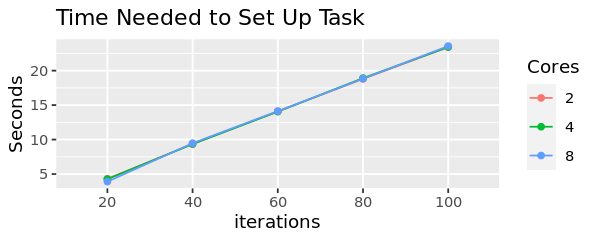

In [17]:
speedup_calc(iterations = seq(from = 20, 100, by = 20), cores = c(1,2, 4, 8), wait_time = .25, evaluate = FALSE)

## Scenario 2 running previous example
Given the cost due to the setup time, parallelization offer very little improvement. 

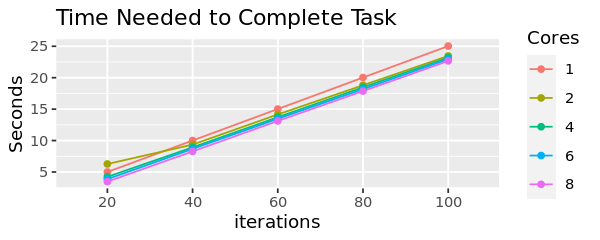

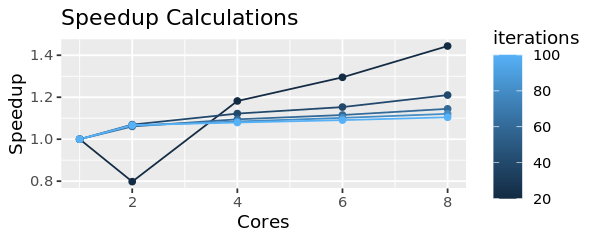

In [18]:
speedup_calc(iterations = seq(from = 20, 100, by = 20), cores = c(1,2, 4, 6, 8), wait_time = .25, evaluate = TRUE)

### Scenario 2 Moderate speedup with a slower iteration
When you incease the wait_time to 1 second, the increase in cores does provide a benefit. 

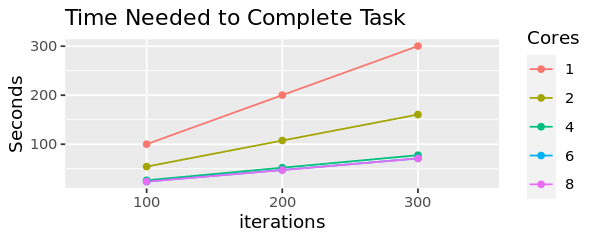

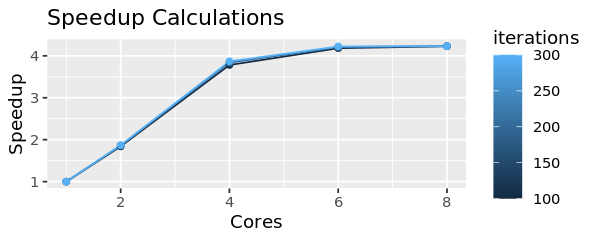

In [19]:
speedup_calc(iterations = seq(from = 100, 300, by = 100), cores = c(1,2,4,6, 8), wait_time = 1, evaluate = TRUE)


### Scenario 3 Best scenario for speedup
The best case for future will be running the code with few iterations but very slow functions. 

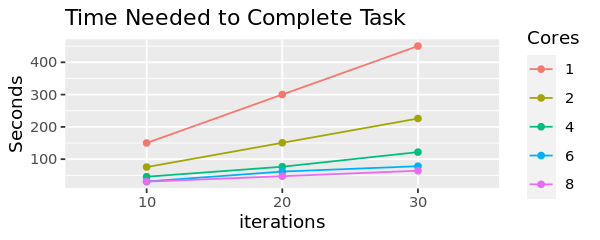

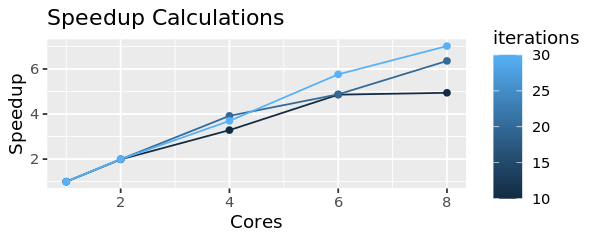

In [20]:
speedup_calc(iterations = seq(from = 10, 30, by = 10), cores = c(1,2,4,6, 8), wait_time = 15, evaluate = TRUE)

## Conclusion
The future package will offer the best performance when there are fewer iterations but each iteration is very slow. With your own code, try running one iteration to see how long it takes and then use that estimate with speedup_calc. Depending on the wait_time and number of iterations, the function should give an estimate on if parallelization is worthwhile (caveat: the code will be slower if the you have a large global environment). 